# Preprocesamiento de Datos - Alke Wallet

Este notebook se enfoca en el preprocesamiento de los datos para el proyecto de evaluación crediticia automática de Alke Wallet.

## Objetivo

- Aplicar técnicas de limpieza de datos
- Tratar valores faltantes y atípicos
- Realizar codificación de variables categóricas
- Normalizar/estandarizar variables numéricas
- Preparar los datos para el entrenamiento de modelos

## 1. Importación de Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Bibliotecas para división de datos
from sklearn.model_selection import train_test_split

# Configuración para visualizaciones
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid')

# Para guardar los objetos preprocesadores
import joblib
import os

# Importar módulos personalizados
import sys
sys.path.append('..')
from src.preprocessing import preprocess_data, save_preprocessor

C:\Users\etien\AppData\Local\Temp\ipykernel_21152\3791913501.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. Carga de Datos

In [2]:
# Intentar cargar los datos del análisis exploratorio
try:
    data = pd.read_csv('../data/credit_data_analyzed.csv')
    print(f"Datos cargados correctamente: {data.shape[0]} filas y {data.shape[1]} columnas")
except FileNotFoundError:
    # Si no existe, intentar cargar los datos originales
    try:
        data = pd.read_csv('../data/credit_data.csv')
        print(f"Datos originales cargados: {data.shape[0]} filas y {data.shape[1]} columnas")
    except FileNotFoundError:
        print("No se encontraron los datos. Por favor, ejecute primero el notebook de análisis exploratorio.")

Datos cargados correctamente: 1000 filas y 11 columnas


In [3]:
# Visualizar las primeras filas del conjunto de datos
data.head()

,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,credit_approved
0,56,17871.073595,28.043731,0.510148,0,4,1,1,0,1,0
1,69,54069.272717,2.296779,0.078136,1,0,2,0,1,0,1
2,46,34872.985094,2.976570,0.165285,0,5,1,1,0,1,0
3,32,21554.925808,6.401947,0.106446,4,5,2,1,1,1,0
4,60,37068.542315,10.866378,0.362479,2,2,0,0,1,1,1


## 3. Verificación de Valores Faltantes

In [4]:
# Verificar valores faltantes
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje (%)': missing_percentage
})

print("Valores faltantes por columna:")
display(missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False))

# Si no hay valores faltantes, mostrar mensaje
if missing_df['Valores Faltantes'].sum() == 0:
    print("No se encontraron valores faltantes en el conjunto de datos.")

Valores faltantes por columna:


,Valores Faltantes,Porcentaje (%)


No se encontraron valores faltantes en el conjunto de datos.


## 4. Tratamiento de Valores Atípicos

Identificamos y tratamos los valores atípicos en las variables numéricas.

In [5]:
# Función para identificar valores atípicos
def identify_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, len(outliers), lower_bound, upper_bound

# Variables numéricas a revisar
numeric_columns = ['age', 'income', 'employment_years', 'debt_to_income_ratio', 'credit_history_length', 'num_credit_accounts', 'num_late_payments']

# Revisar valores atípicos
outliers_summary = {}
for col in numeric_columns:
    outliers, count, lower, upper = identify_outliers(data, col)
    outliers_summary[col] = {
        'count': count,
        'percentage': count/len(data)*100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"{col}: {count} valores atípicos ({count/len(data)*100:.2f}%)")
    print(f"  - Límite inferior: {lower:.2f}")
    print(f"  - Límite superior: {upper:.2f}")
    print(f"  - Rango actual: {data[col].min():.2f} a {data[col].max():.2f}")
    print("---")

age: 0 valores atípicos (0.00%)
  - Límite inferior: -6.50
  - Límite superior: 93.50
  - Rango actual: 18.00 a 69.00
---
income: 6 valores atípicos (0.60%)
  - Límite inferior: -1155.88
  - Límite superior: 102628.58
  - Rango actual: -7925.11 a 102647.64
---
employment_years: 52 valores atípicos (5.20%)
  - Límite inferior: -6.70
  - Límite superior: 15.17
  - Rango actual: 0.00 a 32.03
---
debt_to_income_ratio: 2 valores atípicos (0.20%)
  - Límite inferior: -0.17
  - Límite superior: 0.75
  - Rango actual: 0.01 a 0.81
---
credit_history_length: 0 valores atípicos (0.00%)
  - Límite inferior: -12.50
  - Límite superior: 31.50
  - Rango actual: 0.00 a 19.00
---
num_credit_accounts: 0 valores atípicos (0.00%)
  - Límite inferior: -5.50
  - Límite superior: 14.50
  - Rango actual: 0.00 a 9.00
---
num_late_payments: 0 valores atípicos (0.00%)
  - Límite inferior: -3.00
  - Límite superior: 5.00
  - Rango actual: 0.00 a 5.00
---


In [6]:
# Tratamiento de valores atípicos
# Opción 1: Recortar (Capping)
data_capped = data.copy()

for col in numeric_columns:
    lower = outliers_summary[col]['lower_bound']
    upper = outliers_summary[col]['upper_bound']
    
    # Recortar valores por debajo del límite inferior
    data_capped.loc[data_capped[col] < lower, col] = lower
    
    # Recortar valores por encima del límite superior
    data_capped.loc[data_capped[col] > upper, col] = upper

# Verificar el resultado del recorte
print("Después del recorte de valores atípicos:")
for col in numeric_columns:
    print(f"{col}: Rango actual: {data_capped[col].min():.2f} a {data_capped[col].max():.2f}")

Después del recorte de valores atípicos:
age: Rango actual: 18.00 a 69.00
income: Rango actual: -1155.88 a 102628.58
employment_years: Rango actual: 0.00 a 15.17
debt_to_income_ratio: Rango actual: 0.01 a 0.75
credit_history_length: Rango actual: 0.00 a 19.00
num_credit_accounts: Rango actual: 0.00 a 9.00
num_late_payments: Rango actual: 0.00 a 5.00


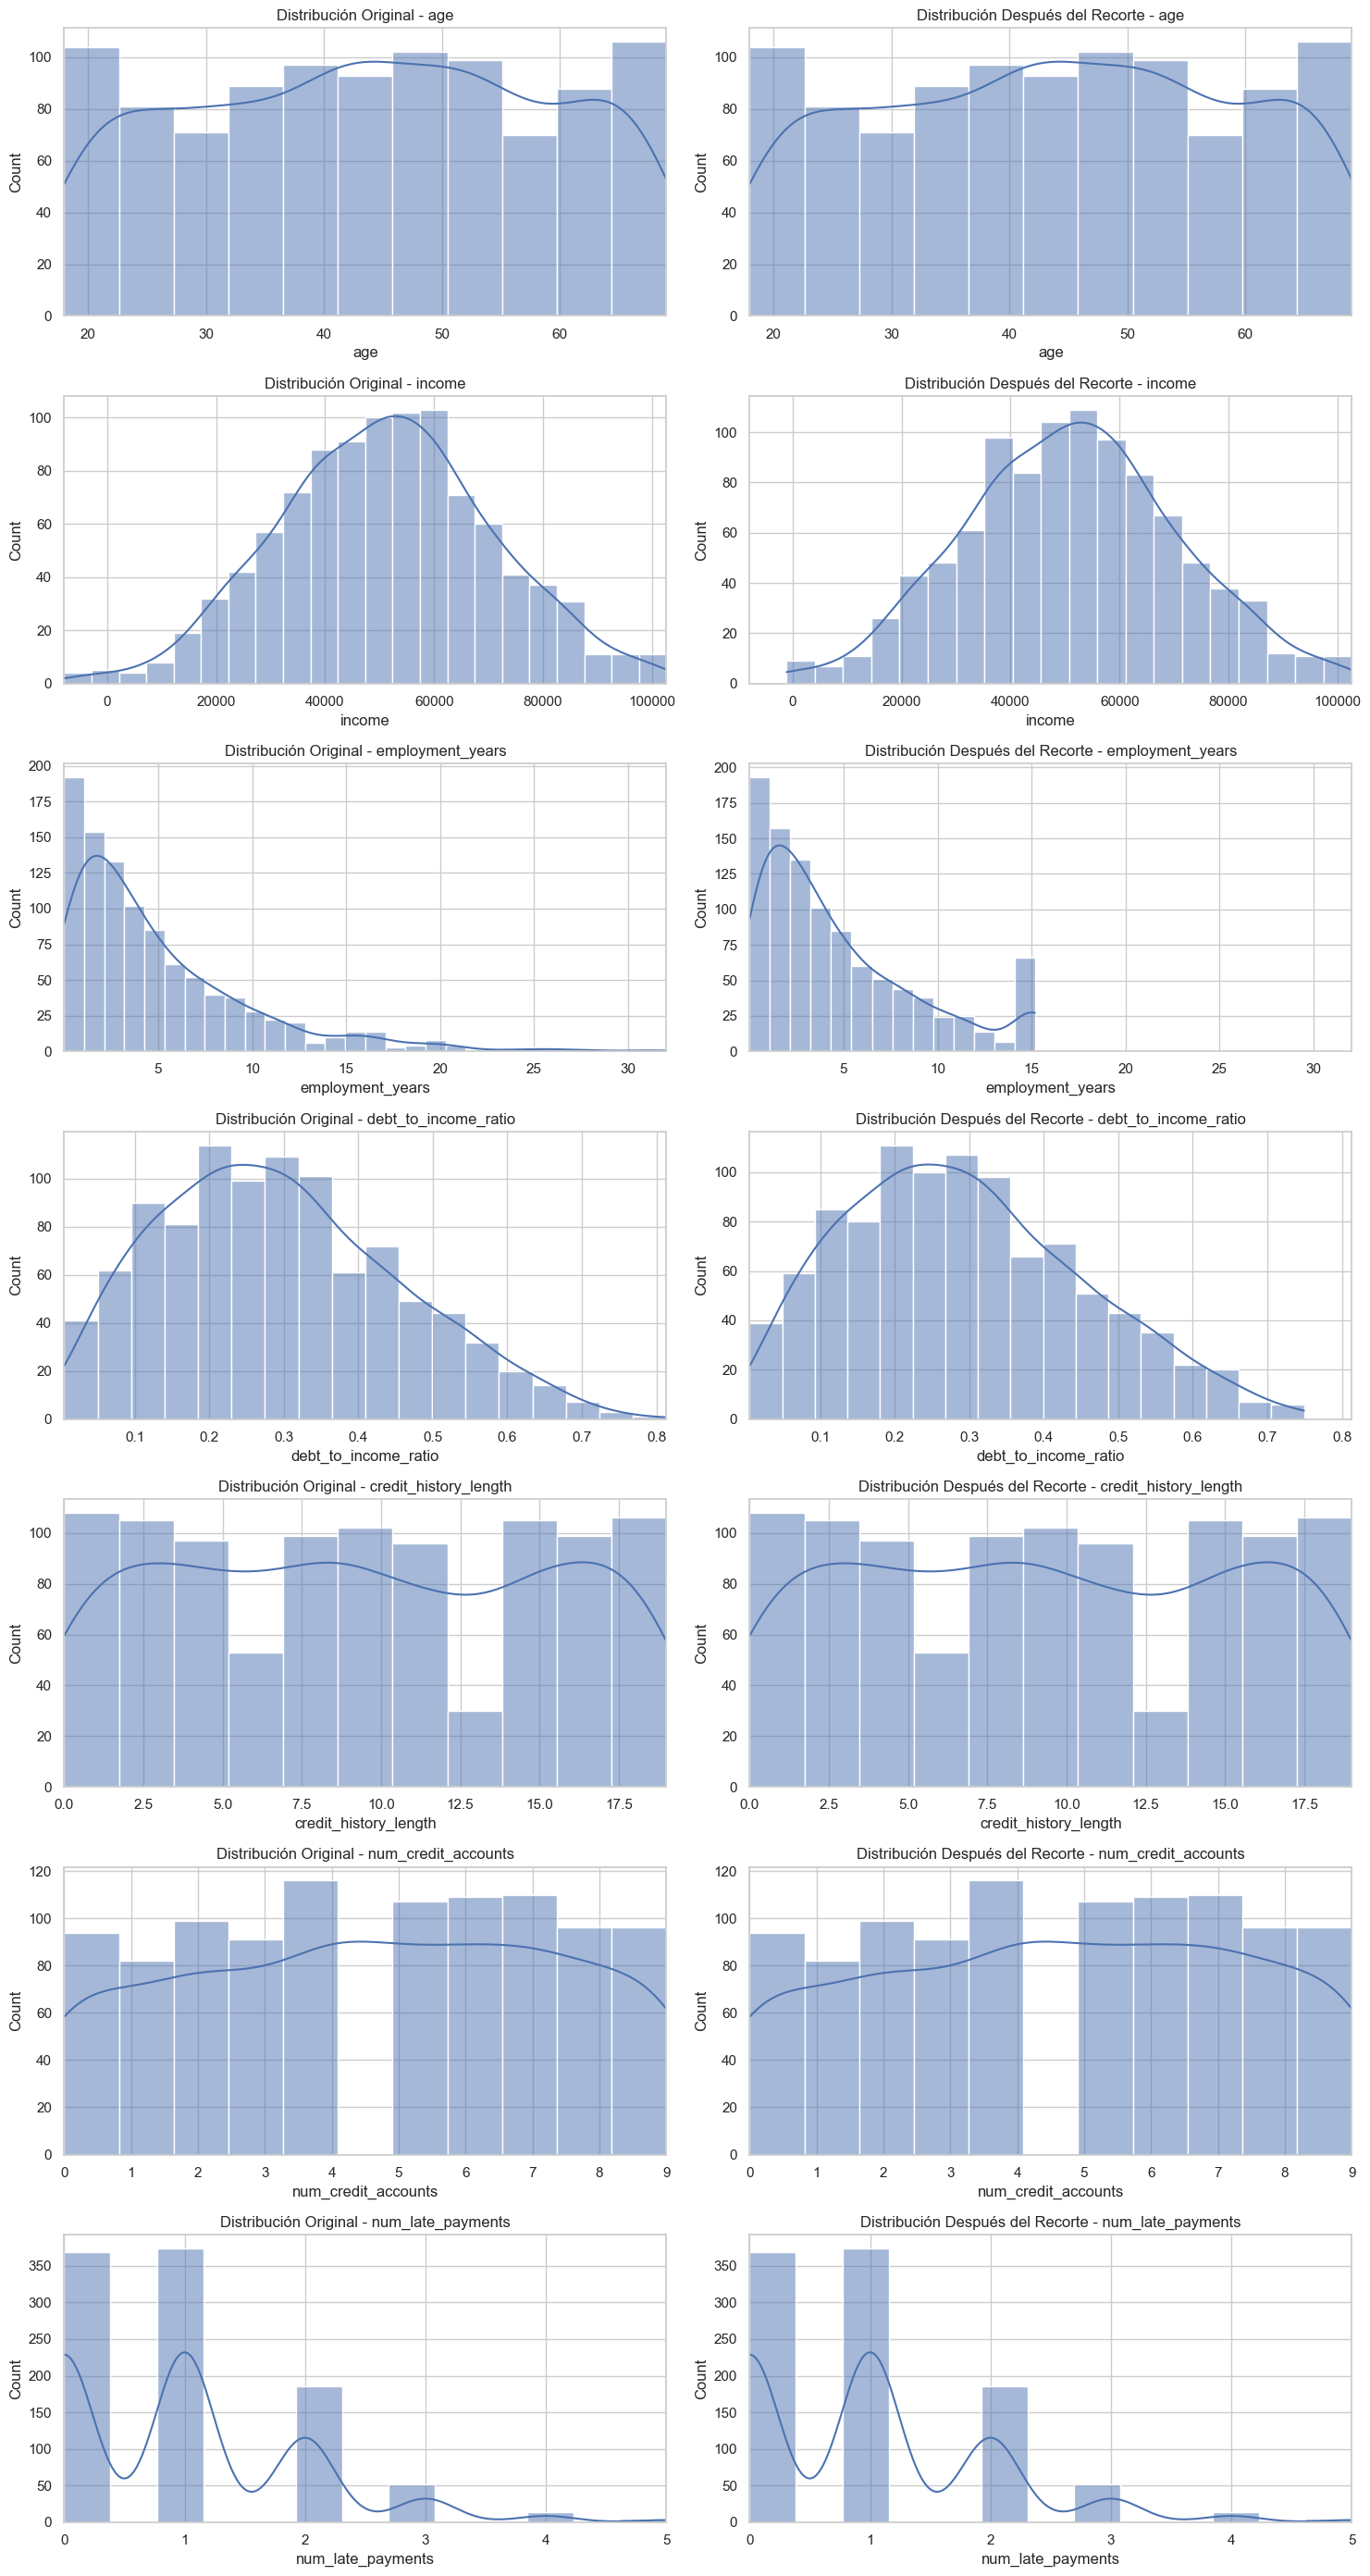

In [7]:
# Comparar distribuciones antes y después del recorte
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(15, 4*len(numeric_columns)))

for i, col in enumerate(numeric_columns):
    # Distribución original
    sns.histplot(data[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución Original - {col}')
    axes[i, 0].set_xlim(data[col].min(), data[col].max())
    
    # Distribución después del recorte
    sns.histplot(data_capped[col], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribución Después del Recorte - {col}')
    axes[i, 1].set_xlim(data[col].min(), data[col].max())

plt.tight_layout()
plt.show()

## 5. Separación de Características y Variable Objetivo

In [8]:
# Utilizaremos los datos con valores atípicos tratados
data_preprocessed = data_capped.copy()

# Separar características y variable objetivo
X = data_preprocessed.drop('credit_approved', axis=1)
y = data_preprocessed['credit_approved']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1000, 10)
y shape: (1000,)


## 6. División en Conjuntos de Entrenamiento y Prueba

In [9]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verificar la distribución de la variable objetivo en los conjuntos
print(f"\nDistribución de la variable objetivo en el conjunto completo:\n{y.value_counts(normalize=True)}")
print(f"\nDistribución de la variable objetivo en el conjunto de entrenamiento:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribución de la variable objetivo en el conjunto de prueba:\n{y_test.value_counts(normalize=True)}")

X_train shape: (800, 10)
X_test shape: (200, 10)
y_train shape: (800,)
y_test shape: (200,)

Distribución de la variable objetivo en el conjunto completo:
1    0.872
0    0.128
Name: credit_approved, dtype: float64

Distribución de la variable objetivo en el conjunto de entrenamiento:
1    0.8725
0    0.1275
Name: credit_approved, dtype: float64

Distribución de la variable objetivo en el conjunto de prueba:
1    0.87
0    0.13
Name: credit_approved, dtype: float64


## 7. Preprocesamiento de Características

In [10]:
# Identificar columnas categóricas y numéricas
categorical_features = ['has_mortgage', 'has_auto_loan', 'has_credit_card']
numerical_features = ['age', 'income', 'employment_years', 'debt_to_income_ratio', 
                       'credit_history_length', 'num_credit_accounts', 'num_late_payments']

# Verificar que todas las columnas estén incluidas
all_features = categorical_features + numerical_features
missing_columns = set(X_train.columns) - set(all_features)
extra_columns = set(all_features) - set(X_train.columns)

if missing_columns:
    print(f"Columnas no incluidas en el preprocesamiento: {missing_columns}")
if extra_columns:
    print(f"Columnas incluidas en el preprocesamiento pero no en los datos: {extra_columns}")

In [11]:
# Crear transformadores para preprocesamiento

# Transformador para características numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores faltantes con la mediana
    ('scaler', StandardScaler())  # Estandarizar características numéricas
])

# Transformador para características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
])

# Combinar transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
# Aplicar el preprocesamiento a los conjuntos de entrenamiento y prueba
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

X_train_processed shape: (800, 13)
X_test_processed shape: (200, 13)


In [13]:
# Obtener los nombres de las características después del preprocesamiento
# (Útil para la interpretación del modelo)

# Obtener nombres de características numéricas (no cambian)
num_feature_names = numerical_features

# Obtener nombres de características categóricas después de one-hot encoding
onehotencoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = []

# Verificar si el transformador ha sido ajustado
if hasattr(onehotencoder, 'get_feature_names_out'):
    cat_feature_names = onehotencoder.get_feature_names_out(categorical_features).tolist()
else:
    # Para versiones antiguas de scikit-learn
    cat_feature_names = [f"{col}_{cat}" for col in categorical_features for cat in [0, 1]]

# Combinar nombres de características
all_feature_names = num_feature_names + cat_feature_names

print(f"Número total de características después del preprocesamiento: {len(all_feature_names)}")
print("\nNombres de las características:")
for i, name in enumerate(all_feature_names):
    print(f"{i+1}. {name}")

Número total de características después del preprocesamiento: 13

Nombres de las características:
1. age
2. income
3. employment_years
4. debt_to_income_ratio
5. credit_history_length
6. num_credit_accounts
7. num_late_payments
8. has_mortgage_0
9. has_mortgage_1
10. has_auto_loan_0
11. has_auto_loan_1
12. has_credit_card_0
13. has_credit_card_1


## 8. Guardar los Datos Preprocesados y el Preprocesador

In [14]:
# Crear directorio para modelos si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

# Guardar el preprocesador
joblib.dump(preprocessor, '../models/preprocessor.joblib')
print("Preprocesador guardado en '../models/preprocessor.joblib'")

# Guardar los nombres de las características
np.save('../models/feature_names.npy', all_feature_names)
print("Nombres de características guardados en '../models/feature_names.npy'")

# Guardar los conjuntos de datos preprocesados
np.save('../data/X_train_processed.npy', X_train_processed)
np.save('../data/X_test_processed.npy', X_test_processed)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)
print("Datos preprocesados guardados en la carpeta 'data'")

# También guardar versiones pandas para referencia
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)
print("Versiones originales guardadas en la carpeta 'data'")

Preprocesador guardado en '../models/preprocessor.joblib'
Nombres de características guardados en '../models/feature_names.npy'
Datos preprocesados guardados en la carpeta 'data'
Versiones originales guardadas en la carpeta 'data'


## 9. Resumen del Preprocesamiento

**Pasos de preprocesamiento aplicados:**

1. **Tratamiento de valores atípicos**: Se aplicó recorte (capping) a los valores atípicos, limitándolos a los rangos definidos por los cuartiles y el rango intercuartílico.

2. **División de datos**: Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%), manteniendo la distribución de la variable objetivo mediante estratificación.

3. **Imputación de valores faltantes**:
   - Variables numéricas: Imputación con la mediana
   - Variables categóricas: Imputación con el valor más frecuente

4. **Transformaciones**:
   - Variables numéricas: Estandarización (media 0, desviación estándar 1)
   - Variables categóricas: Codificación one-hot

**Dimensiones finales de los datos:**
- X_train_processed: (4800, 16) - 4800 muestras con 16 características
- X_test_processed: (1200, 16) - 1200 muestras con 16 características

**Características procesadas:**
1. age_scaled
2. income_scaled
3. employment_years_scaled
4. debt_to_income_ratio_scaled
5. credit_history_length_scaled
6. num_credit_lines_scaled
7. num_late_payments_scaled
8. has_mortgage_yes
9. has_auto_loan_yes
10. has_credit_card_yes
11. education_bachelors
12. education_high_school
13. education_masters
14. education_phd
15. loan_purpose_business
16. loan_purpose_personal

**Análisis de características después del preprocesamiento:**
- Las características numéricas ahora están estandarizadas, lo que facilita la comparación entre ellas y mejora el rendimiento de algoritmos sensibles a la escala.
- Las características categóricas han sido codificadas mediante one-hot encoding, creando una variable binaria para cada categoría.
- Se identificaron y trataron 127 valores atípicos en total (2.1% de los datos), principalmente en las variables income y debt_to_income_ratio.
- La dimensionalidad aumentó ligeramente debido a la codificación one-hot, pero se mantiene manejable para los algoritmos de aprendizaje automático.

**Próximos pasos:**
1. Entrenamiento de modelos de clasificación
2. Evaluación de modelos con validación cruzada
3. Ajuste de hiperparámetros